In [ ]:
!python -m spacy download "pt_core_news_sm"

In [2]:
# import psycopg2
import pandas as pd
import numpy as np
import paramiko
import json
import hashlib

from pandas.io import sql as psql

from tqdm import tqdm
from tqdm._tqdm_notebook import tqdm_notebook # Beta

# from pre_processing.pre_processing import BatchProcessing

from zipfile import ZipFile
from matplotlib import pyplot as plt

tqdm_notebook.pandas()

In [11]:
def page_split(row):
    split = row.text.split('-----------------')
    if len(split) == 1:
        split += [None]
    elif len(split) > 2:
        split = ['-----------------'.join(split), None]

    return pd.Series([row.document_id, row.label] + split, index=['document_id', 'label', 'first_page', 'second_page'])

In [3]:
def report_duplicated(df, group_name='first_page'):
    if 'text' in df:
        df = df.apply(page_split, axis=1)
    group_text = df.groupby([group_name, ])
    
    new_df = group_text.apply(lambda x: pd.Series(
        data=[x.shape[0], x.label.duplicated(keep=False).all(), x.label.tolist()],
        index=['dup_count', 'label_conflict', 'labels'])
    ).reset_index()
        
    docs = []
    new_df[(new_df.dup_count > 1) & ~new_df.label_conflict].apply(lambda x: docs.append(x[group_name]), axis=1)
    df_label_free = df[~df[group_name].isin(docs)]
        
    total_count = new_df.dup_count.sum()
    dups_count = new_df[new_df.dup_count > 1].dup_count.sum()
    df_dups = df_label_free[df_label_free.duplicated(group_name, keep=False)]
    df_free = df_label_free.drop_duplicates(group_name, keep='first')
    count_labels = new_df[(new_df.dup_count > 1) & ~new_df.label_conflict]
        
    print('# total docs: ', total_count)
    print('# docs duplicates: ', dups_count)
    print('# docs with conflict labels: ', count_labels.dup_count.sum())
    print('# docs keeping first: ', df_free.shape[0])
    
    return total_count, dups_count, df_dups, df_free, count_labels

# 24-08-2018

In [43]:
def gen_pages(row):
    if pd.isna(row.pages):
        return []
    else:
        return eval(row.pages)
    
def first_page(row):
    first_page = None
    if row.pages == []:
        split = row.body.split('-----------------')
        if len(split) == 1:
            first_page = split[0]
        elif len(split) > 2:
            first_page = '-----------------'.join(split)
        else:
            first_page = split[0]
    else:
        first_page = row.pages[0]['body']
    return first_page

def concat_doc(row):
    if row.pages == []:
        return row.body
    else:
        hashs = map(lambda doc: hashlib.sha256(doc['body'].encode('utf8')).hexdigest(), row.pages)
        return ' '.join(hashs)

In [44]:
with ZipFile('data/Annotation-24-08-2018.zip') as zip_dir:
    df_review_dump = pd.read_csv(zip_dir.open('dataset-old-reviewed-low_trust-16-08-2018.csv'))
df_review_dump.head()

,body,document_id,label,pages,path,source_pages
0,TJI/AC DIRETORIA JUDICIÁRIA f15.000002\n\nPROC...,21,ARE,[{'body': 'TJI/AC DIRETORIA JUDICIÁRIA f15.000...,/raw/339/AI_855054/AI_855054_1181350_47_300520...,first
1,\n\nPODER JUDICIÁRIO DO ESTADO DO ACRE\nTrib...,30,Acordão,[{'body': ' \n\nPODER JUDICIÁRIO DO ESTADO DO...,/raw/339/AI_855054/AI_855054_1181361_1272_3005...,first
2,\n\nPODER JUDICIÁRIO DO ESTADO DO ACRE\nTribu...,40,Outro,[{'body': ' \n\nPODER JUDICIÁRIO DO ESTADO DO ...,/raw/339/AI_855433/AI_855433_1231718_1060_3005...,first
3,PODER JUDICIÁRIO DO ESTADO DO ACRE\nTribunal d...,47,Outro,[{'body': 'PODER JUDICIÁRIO DO ESTADO DO ACRE\...,/raw/339/AI_855435/AI_855435_1232534_1060_3105...,first
4,TRIBUNAL DE JUSTIÇA DE MINAS GERAIS\n PODER JU...,74,Outro,"[{'body': ""TRIBUNAL DE JUSTIÇA DE MINAS GERAIS...",/raw/339/AI_858116/AI_858116_2424429_1060_0408...,first


In [45]:
df_review_dump['pages'] = df_review_dump.progress_apply(gen_pages, axis=1)
df_review_dump['first_page'] = df_review_dump.progress_apply(first_page, axis=1)
df_review_dump['page_hash'] = df_review_dump.progress_apply(concat_doc, axis=1)

In [46]:
total_review, count_review, df_dups_review, df_review_free, new_review_labels_conflict = report_duplicated(df_review_dump, 'page_hash')

# total docs:  8161
# docs duplicates:  0
# docs with conflict labels:  0
# docs keeping first:  8161


## 01-08-2018

In [240]:
with ZipFile('data/Annotation-01-08-2018.zip') as zip_dir:
    df_new_dump = pd.read_csv(zip_dir.open('dataset_pecas_ext-01_08.csv'), sep=';')

In [241]:
## Process dump to generate textual data to compare

df_new_dump['pages'] = df_new_dump.progress_apply(lambda x: eval(x.pages), axis=1)
df_new_dump['first_page'] = df_new_dump.progress_apply(lambda x: x.pages[0]['body'], axis=1)
df_new_dump['page_hash'] = df_new_dump.progress_apply(lambda x: ' '.join([hashlib.sha256(doc['body'].encode('utf8')).hexdigest() for doc in x.pages]), axis=1)

In [242]:
total_new_dump, count_new_dump, df_dups_new_dump, df_new_dump_free, new_dump_labels_conflict = report_duplicated(df_new_dump, 'page_hash')

# total docs:  7644
# docs duplicates:  1015
# docs with conflict labels:  63
# docs keeping first:  6847


## 26-07-2018

In [243]:
with ZipFile('data/Annotation-26-07-2018.zip') as zip_dir:
    df_test_dump = pd.read_csv(zip_dir.open('test_types-26-07-18.csv'))
    df_train_dump = pd.read_csv(zip_dir.open('train_types-26-07-18.csv'))
df = pd.concat([df_test_dump, df_train_dump], keys=['test', 'train'])
print('columns {}\n\n\tsize of test {}\n\tsize of train {}\n\tconcat size {}\n'
      .format(', '.join(df.columns), df_test_dump.shape, df_train_dump.shape, df.shape))

columns text, document_id, label

	size of test (3016, 3)
	size of train (7035, 3)
	concat size (10051, 3)



In [244]:
print('Teste 26/07')
total_test, count_test, df_dups_test, df_test_free, test_labels_conflict = report_duplicated(df_test_dump)
print('Free off duplication: ', ~df_test_free.duplicated(['first_page', ], keep=False).any())

Teste 26/07
# total docs:  3016
# docs duplicates:  534
# docs with conflict labels:  12
# docs keeping first:  2645
Free off duplication:  True


In [245]:
print('Train 26/07')
total_train, count_train, df_dups_train, df_train_free, train_labels_conflict = report_duplicated(df_train_dump)
print('Free off duplication: ', ~df_train_free.duplicated('first_page', keep=False).any())

Train 26/07
# total docs:  7035
# docs duplicates:  1985
# docs with conflict labels:  87
# docs keeping first:  5692
Free off duplication:  True


In [246]:
print('Concatenated 26/07')
df_dump = pd.concat([df_test_free, df_train_free], keys=['test', 'train'])
total_dump, count_dump, df_dups_dump, df_dump_free, dump_labels_conflict = report_duplicated(df_dump)
print('Free off duplication: ', ~df_dump_free.duplicated('first_page', keep=False).any())

Concatenated 26/07
# total docs:  8337
# docs duplicates:  1114
# docs with conflict labels:  36
# docs keeping first:  7762
Free off duplication:  True


## 27-06-2018

In [247]:
path_train='data/27-06-2018-Treino-Tag-pre-processed.csv'
df_train = pd.read_csv(path_train, usecols=['label', 'text'])

path_test='data/27-06-2018-Teste-Tag-pre-processed.csv'
df_test = pd.read_csv(path_test, usecols=['label', 'text'])

path_validation='data/27-06-2018-Validacao-Tag-pre-processed.csv'
df_validation = pd.read_csv(path_validation, usecols=['label', 'text'])

df_train.shape, df_test.shape, df_validation.shape

((7408, 2), (1056, 2), (2118, 2))

In [248]:
print('Train 27/06')
df_train['document_id'] = np.empty(df_train.index.size)
total_train, count_train, df_dups_train, df_train_free, train_labels_conflict = report_duplicated(df_train)

Train 27/06
# total docs:  7408
# docs duplicates:  2676
# docs with conflict labels:  206
# docs keeping first:  5621


In [249]:
print('Validation 27/06')
df_validation['document_id'] = np.empty(df_validation.index.size)
total_validation, count_validation, df_dups_validation, df_validation_free, validation_labels_conflict = report_duplicated(df_validation)

Validation 27/06
# total docs:  2118
# docs duplicates:  316
# docs with conflict labels:  57
# docs keeping first:  1898


In [250]:
print('Test 27/06')
df_test['document_id'] = np.empty(df_test.index.size)
total_test, count_test, df_dups_test, df_test_free, test_labels_conflict = report_duplicated(df_test)

Test 27/06
# total docs:  1056
# docs duplicates:  99
# docs with conflict labels:  4
# docs keeping first:  987


In [251]:
print('Concatenated 27/06')
df = pd.concat([df_train_free, df_validation_free, df_test_free], keys=['train', 'validation', 'test'])
total, count, df_dups, df_free, labels_conflict = report_duplicated(df)

Concatenated 27/06
# total docs:  8506
# docs duplicates:  794
# docs with conflict labels:  74
# docs keeping first:  8057


# Split dataset

In [49]:
def split_dataset(df, groupby='first_page'):
    train = df.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=0.7, random_state=5602))
    rest = df[~df.index.isin(train.index)]
    validation = rest.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=2.0/3.0, random_state=5602))
    test = rest[~rest.index.isin(validation.index)]
    # Assert that datasets hasn't shared data
    assert not pd.concat([train, test, validation]).duplicated([groupby], keep=False).any(), "Has some first page duplicated"
    
    counts = df.label.value_counts()
    data = np.array([counts, train.label.value_counts(), validation.label.value_counts(), test.label.value_counts(), counts.index])
    inds = np.arange(counts.size)
    plt.bar(inds - 0.2, data[0], width=0.5)
    plt.bar(inds - 0.1, data[1], width=0.5)
    plt.bar(inds + 0.1, data[2], width=0.5)
    plt.bar(inds + 0.2, data[3], width=0.5)
    plt.xticks(inds, counts.index)

    return data, train, validation, test
    

# 24-08-2018

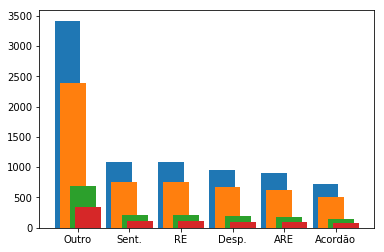

In [50]:
_, review_train, review_validation, review_test = split_dataset(df_review_free, 'page_hash')

In [52]:
review_train.to_csv('data/train-24-08-2018.csv', index=False)

review_validation.to_csv('data/validation-24-08-2018.csv', index=False)

review_test.to_csv('data/test-24-08-2018.csv', index=False)

## 01-08-2018

array([[2802, 1096, 915, 819, 628, 554, 17, 16],
       [1961, 767, 640, 573, 440, 388, 12, 11],
       [561, 219, 183, 164, 125, 111, 3, 3],
       [280, 110, 92, 82, 63, 55, 2, 2],
       ['Outro', 'Sent.', 'ARE', 'Acordão', 'RE', 'Desp.', 'D. Agrav',
        'P. Agrav']], dtype=object)

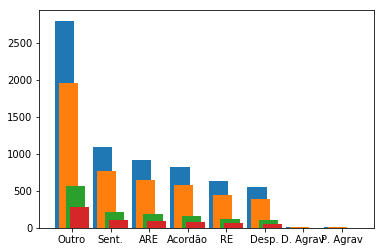

In [253]:
_, new_dump_train, new_dump_validation, new_dump_test = split_dataset(df_new_dump_free, 'page_hash')
_

In [254]:
new_dump_train.to_csv('data/train-01-08-2018-wo-duplicates.csv', index=False)

new_dump_validation.to_csv('data/validation-01-08-2018-wo-duplicates.csv', index=False)

new_dump_test.to_csv('data/test-01-08-2018-wo-duplicates.csv', index=False)

## 26-07-2018

In [ ]:
_, dump_train, dump_validation, dump_test = split_dataset(df_dump_free)
_

In [22]:
dump_train.to_csv('data/train-26-07-2018-wo-duplicates.csv', index=False)

dump_validation.to_csv('data/validation-26-07-2018-wo-duplicates.csv', index=False)

dump_test.to_csv('data/test-26-07-2018-wo-duplicates.csv', index=False)

## 27-06-2018

array([[3424, 1274, 1128, 973, 615, 562, 59, 22],
       [2397, 892, 790, 681, 430, 393, 41, 15],
       [685, 255, 225, 195, 123, 113, 12, 5],
       [342, 127, 113, 97, 62, 56, 6, 2],
       ['Outro', 'ARE', 'Sent.', 'Acordao', 'RE', 'Desp.', 'P. Agrav',
        'D. Agrav']], dtype=object)

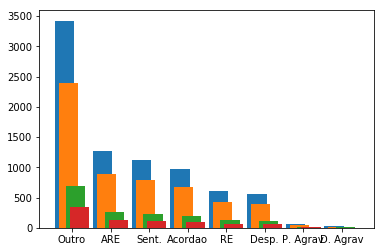

In [23]:
_, train, validation, test = split_dataset(df_free)
_

In [24]:
train.to_csv('data/train-27-06-2018-wo-duplicates.csv', index=False)

validation.to_csv('data/validation-27-06-2018-wo-duplicates.csv', index=False)

test.to_csv('data/test-27-06-2018-wo-duplicates.csv', index=False)

# Validation on Database to LegalLabs

In [2]:
# with ZipFile('/home/isis/Annotated_types.zip') as zip_dir:
#     df_test = pd.read_csv(zip_dir.open('test_types-26-07-18.csv'))
#     df_train = pd.read_csv(zip_dir.open('train_types-26-07-18.csv'))
# df = pd.concat([df_test, df_train])
# df.shape

In [3]:
# texts = df.progress_apply(page_split, axis=1).sort_values('document_id')
# texts.head()

In [4]:
# for idx, doc in texts[~texts.second_page.isnull()].iterrows():
#     print('############', idx, '#############\n', doc.first_page, '--------\n', doc.second_page)

In [5]:
# DSN = "dbname=postgres user=postgres host=toth.lades.unb.br"

In [6]:
# # pages.index = pdfs_documents.page_to - pdfs_documents.page_from
# QUERY = """
# SELECT documents.id as document_id, pages.index as page, pages.body as text FROM documents
#     INNER JOIN pages ON documents.id = pages.document_id
#     INNER JOIN pdfs_documents ON documents.id = pdfs_documents.document_id
#     WHERE (
#         (pages.body = %s AND pages.index = 0)
#         OR
#         (pages.body = %s AND pages.index = 1)
#     )
#     ORDER BY documents.id, pages.index;
# """

# docs = []
# with psycopg2.connect(DSN) as con:
#     with con.cursor() as cur:
#         for doc in tqdm(texts.apply(lambda x: (x.first_page, x.second_page), axis=1)):
#             query = cur.mogrify(QUERY, doc)
# #             df_sql = psql.read_sql(QUERY, con)
#             cur.execute(query)
#             for row in cur.fetchall():
#                 docs.append(row)

In [7]:
# # pd.DataFrame(docs, columns=['document_id', 'page', 'text']).to_csv('/home/isis/dump_pages.csv', index=False)
# docs = pd.read_csv('/home/isis/dump_pages.csv')
# docs

In [8]:
# def pages_to_columns(document):
#     unique_documents = document.drop_duplicates(['document_id', 'page'], keep='first')
#     pages = unique_documents.text.tolist()
#     if len(pages) == 1:
#         pages += [None]
#     elif len(pages) == 2:
#         pass
#     else:
#         print(pages)
#     return pd.Series(pages, index=['first_page', 'second_page'])

In [9]:
# ndocs = docs.groupby('document_id').progress_apply(pages_to_columns).reset_index()

# texts = df_dump_free.progress_apply(page_split, axis=1)

In [10]:
# display(ndocs.head())
# display(ndocs.shape)
# display(texts.head())
# display(texts.shape)

In [11]:
# texts[texts.first_page.isin(ndocs.first_page)]